In this notebook, we would use the German credit risk data from the UCI Machine Learning repository and use it to build a classifier that can efficiently identify bad loans.

Before we start, there are couple of things we should be mindful of:

1. This data is quite old (from 1994), hence the amounts represented are in Deutsch Marks (not Euros).
2. Given the fact that this data was collected a couple of years after German reunification, there is a possibility that the banks would've been operating under different conditions than they are right now. For example, in the early 1990s, Germany had a much higher [interest rate](https://www.ecb.europa.eu/pub/pdf/other/mb200309_focus03.en.pdf) compared to right now. One of the reasons for this was to keep inflation under control. On the other hand, post-unification, a lot of people in the former East Germany realized the marked difference in living standards across the two halves. Hence, we can say that given the access to easy credit in a liberal democracy, German banks were receiving a lot of loan applications in the 1990s, specially from East Germans who wanted to catch up in terms of lifestyle. We can hypothesize that this would've made banks more cautionary when giving out loans. 
3. This data is quite limited. With only 1000 observations and very limited set of variables, predicting is hard. In today's day and age, credit scores (SCHUFA) in Germany are a good way od juding an applicant's credit-worthiness. However, in this dataset, we don't have access to this.

## 1. Importing Data & Missing Values

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from google.colab import files
files.upload()

ModuleNotFoundError: No module named 'google'

In [4]:
df = pd.read_csv("german_credit_data .csv", index_col=0)
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


We can see that we only have missing values in two columns (Saving accounts & Checking account). 

I think we can assume that NaNs in both of these columns imply that these people don't have bank accounts. Because if they did, I think that would've been logged into the data. Hence, we can fill in this missing values with 'none'. 

In [5]:
df.isna().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

In [6]:
for col in ['Saving accounts', 'Checking account']:
    df[col].fillna('none', inplace=True)


Let's encode the actual values for jobs as described in the data description. Later on, this will make one hot encoding much easier. 

In [7]:
j = {0: 'unskilled and non-res', 1: 'unskilled and res', 2: 'skilled', 3: 'highly skilled'}
df['Job'] = df['Job'].map(j)

df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,skilled,own,none,little,1169,6,radio/TV,good
1,22,female,skilled,own,little,moderate,5951,48,radio/TV,bad
2,49,male,unskilled and res,own,little,none,2096,12,education,good
3,45,male,skilled,free,little,little,7882,42,furniture/equipment,good
4,53,male,skilled,free,little,little,4870,24,car,bad


## 2. EDA & Data Visualization


### 2.1. Distribution of Risk across Job Type and Gender


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


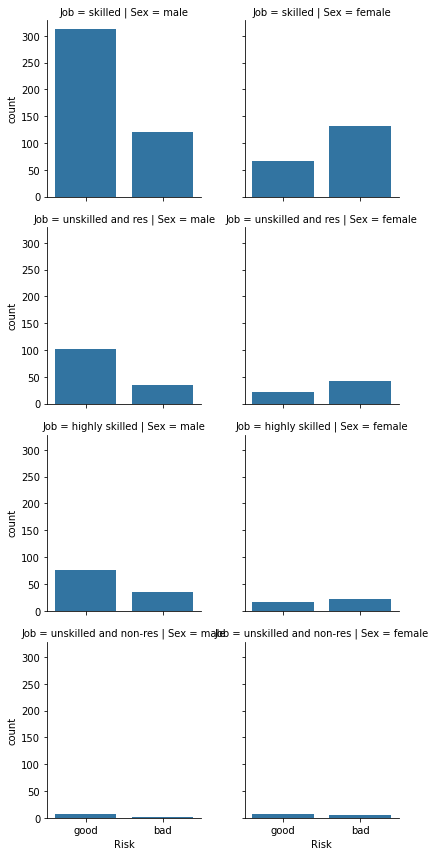

In [8]:
g = sns.FacetGrid(df, col="Sex",  row="Job")
g = g.map(sns.countplot, "Risk")

### 2.2. Distribution of Risk across Housing Status



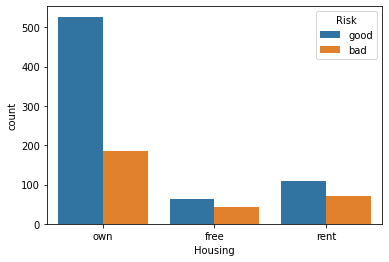

In [9]:
sns.countplot(x="Housing", hue="Risk", data=df)
plt.show()


### 2.3. Distribution of Risk across Bank Account Status


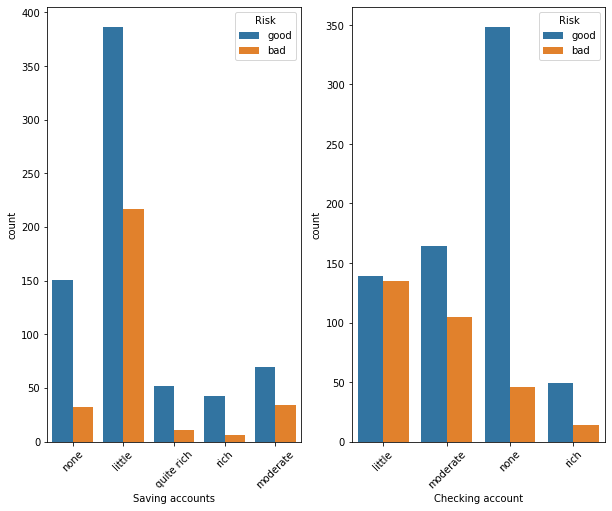

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,8))
sns.countplot(x="Saving accounts", hue="Risk", data=df, ax=ax1)
sns.countplot(x="Checking account", hue="Risk", data=df, ax=ax2)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)


fig.show()

### 2.4. Boxplots of Distribution of Credit Amounts Across Several Variables



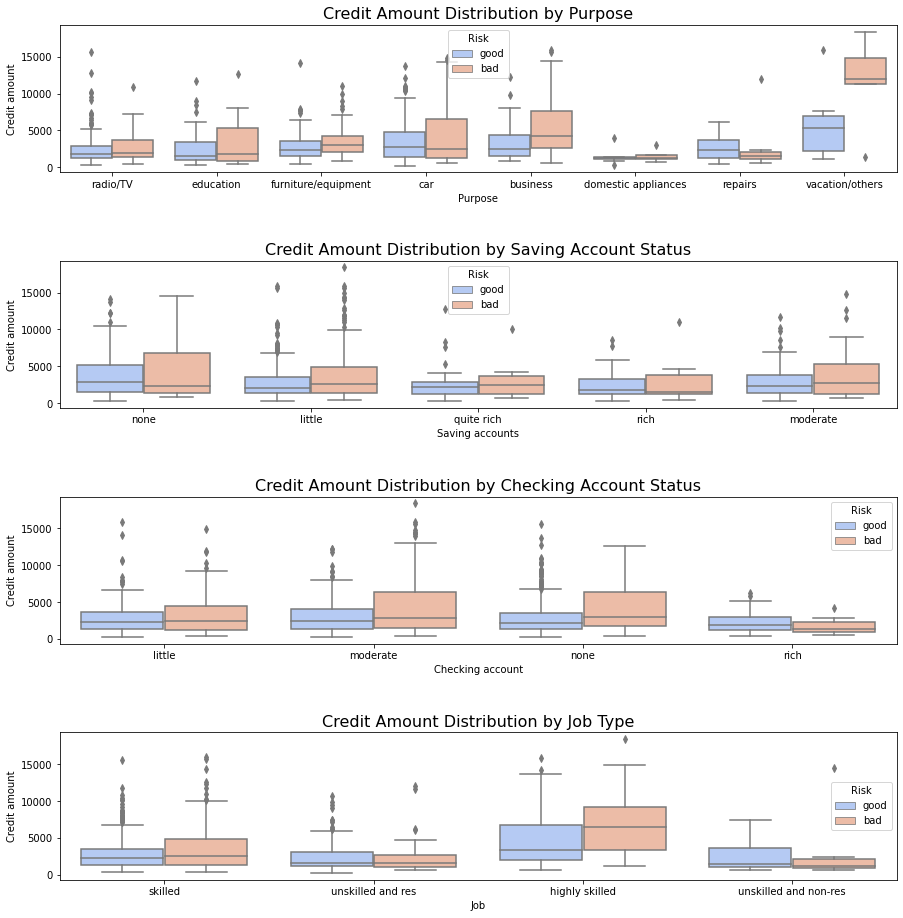

In [11]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(15,25))

sns.boxplot(x="Purpose", y="Credit amount", data=df, hue="Risk", palette="coolwarm", ax=ax1)
sns.boxplot(x="Saving accounts", y="Credit amount", data=df, hue="Risk", palette="coolwarm", ax=ax2)
sns.boxplot(x="Checking account", y="Credit amount", data=df, hue="Risk", palette="coolwarm", ax=ax3)
sns.boxplot(x="Job", y="Credit amount", data=df, hue="Risk", palette="coolwarm", ax=ax4)

ax1.set_title("Credit Amount Distribution by Purpose", fontsize=16)
ax2.set_title("Credit Amount Distribution by Saving Account Status", fontsize=16)
ax3.set_title("Credit Amount Distribution by Checking Account Status", fontsize=16)
ax4.set_title("Credit Amount Distribution by Job Type", fontsize=16)

plt.subplots_adjust(hspace = 0.6, top = 0.6)
plt.show()


### 2.5. Credit Amount Distribution by Age and Loan Duration
 

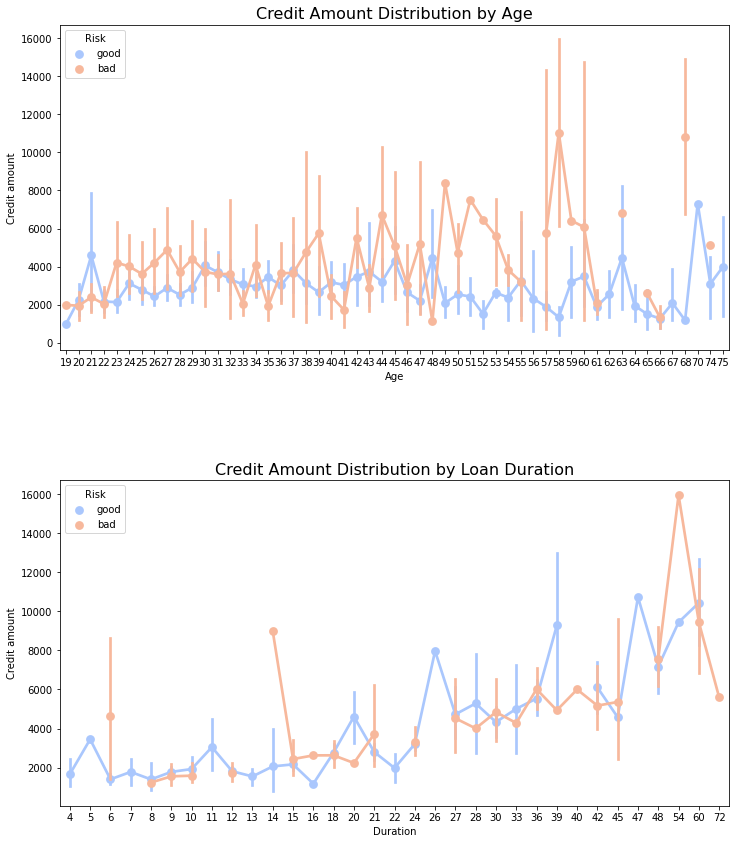

In [12]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,14))

sns.pointplot(x="Age", y="Credit amount", data=df, hue="Risk", palette="coolwarm", ax=ax1)
sns.pointplot(x="Duration", y="Credit amount", data=df, hue="Risk", palette="coolwarm", ax=ax2)

ax1.set_title("Credit Amount Distribution by Age", fontsize=16)
ax2.set_title("Credit Amount Distribution by Loan Duration", fontsize=16)

plt.subplots_adjust(wspace = 0.4, hspace = 0.4,top = 0.9)
plt.show()

## 3. Feature Engineering

### 3.1. Getting Dummies


In [13]:
# getting dummies for all the categorical variables
dummies_columns = ['Job', 'Purpose', 'Sex', 'Housing', 'Saving accounts', 'Checking account']
for col in dummies_columns:
    df = df.merge(pd.get_dummies(df[col], drop_first=True, prefix=str(col)), left_index=True, right_index=True) 

# encoding risk as binary
r = {"good":0, "bad": 1}
df['Risk'] = df['Risk'].map(r)

# drop redundant variables
columns_to_drop = ['Job', 'Purpose','Sex','Housing','Saving accounts','Checking account']
df.drop(columns_to_drop, axis=1, inplace=True)

df.head()

    


,Age,Credit amount,Duration,Risk,Job_skilled,Job_unskilled and non-res,Job_unskilled and res,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Sex_male,Housing_own,Housing_rent,Saving accounts_moderate,Saving accounts_none,Saving accounts_quite rich,Saving accounts_rich,Checking account_moderate,Checking account_none,Checking account_rich
0,67,1169,6,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0
1,22,5951,48,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
2,49,2096,12,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0
3,45,7882,42,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
4,53,4870,24,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


### 3.2. Getting Log Amounts


In [14]:
df['Log_CA'] = np.log(df['Credit amount'])

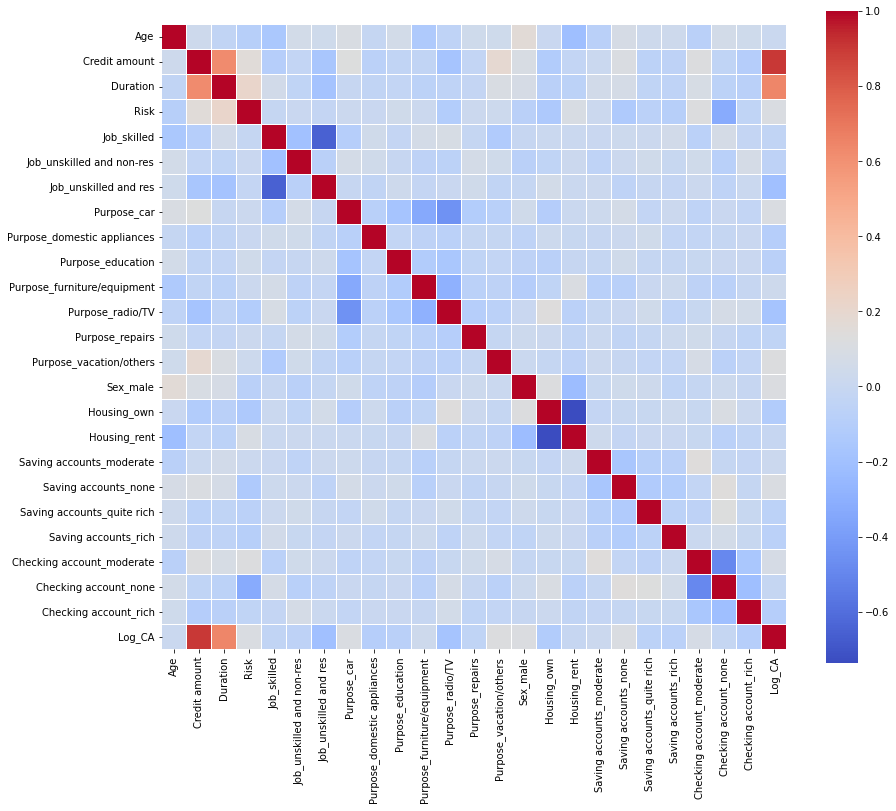

In [15]:
plt.figure(figsize=(14,12))
sns.heatmap(df.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True,  linecolor='white', cmap='coolwarm')
plt.show()

## 4. Base Models


In [16]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB



In [17]:
X = df.drop(['Risk', 'Credit amount'], axis=1).values
y = df['Risk'].values

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42)



### 4.1. Logistic Regression

In [18]:
log = LogisticRegression()
log.fit(X_train, y_train)
y_pred_log = log.predict(X_test)
print(accuracy_score(y_pred_log, y_test))
print(confusion_matrix(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))



0.74
[[126  15]
 [ 37  22]]
              precision    recall  f1-score   support

           0       0.77      0.89      0.83       141
           1       0.59      0.37      0.46        59

    accuracy                           0.74       200
   macro avg       0.68      0.63      0.64       200
weighted avg       0.72      0.74      0.72       200



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


### 4.2. K-Nearest Neighbors

In [19]:
"""knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid={'n_neighbors':range(1,20)}, scoring='recall')
grid.fit(X_train, y_train)

grid.best_params_

for i in range(0, len(grid.cv_results_['mean_test_score'])):
    print('N_Neighbors {}: {} '.format(i+1, grid.cv_results_['mean_test_score'][i]*100))"""
    
# recall peaks at k = 1

knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print(accuracy_score(y_pred_knn, y_test))
print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

    

0.685
[[117  24]
 [ 39  20]]
              precision    recall  f1-score   support

           0       0.75      0.83      0.79       141
           1       0.45      0.34      0.39        59

    accuracy                           0.69       200
   macro avg       0.60      0.58      0.59       200
weighted avg       0.66      0.69      0.67       200



### 4.3. Support Vector Classification

In [20]:
"""param_grid_svc = {"gamma": [0.1,0.5,1,5,10,50,100],
                  "C": [0.1,0.5,1,5,10,50,100]}

svc = SVC(kernel='linear')

gs_svc = GridSearchCV(svc, param_grid = param_grid_svc, cv=5, scoring='recall', verbose=4)
gs_svc.fit(X_train, y_train)

gs_svc.best_params_ # gamma = , C = """

svc = SVC(kernel='linear', gamma=10, C=0.8)
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)
print(accuracy_score(y_pred_svc, y_test))
print(confusion_matrix(y_test, y_pred_svc))
print(classification_report(y_test, y_pred_svc))
    


0.76
[[129  12]
 [ 36  23]]
              precision    recall  f1-score   support

           0       0.78      0.91      0.84       141
           1       0.66      0.39      0.49        59

    accuracy                           0.76       200
   macro avg       0.72      0.65      0.67       200
weighted avg       0.75      0.76      0.74       200



### 4.4. Random Forests

In [21]:
"""param_grid_rf = {"max_depth": range(3,10),
                  "max_features": [3,5,7,9,11,13,15,17,20],
                  "min_samples_leaf": [5,10,15,20,25,30],
                  "n_estimators": [3,5,10,25,50,150]}

rf = RandomForestClassifier()
gs_rf = GridSearchCV(rf, param_grid=param_grid_rf, cv=5, scoring="recall", verbose=4)
gs_rf.fit(X_train, y_train)

gs_rf.best_params_
"""
# {'max_depth': 9, 'max_features': 15, 'min_samples_leaf': 5, 'n_estimators': 25}


rf = RandomForestClassifier(max_depth=9, max_features=15, min_samples_leaf=5, n_estimators=25)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print(accuracy_score(y_pred_rf, y_test))
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


0.735
[[128  13]
 [ 40  19]]
              precision    recall  f1-score   support

           0       0.76      0.91      0.83       141
           1       0.59      0.32      0.42        59

    accuracy                           0.73       200
   macro avg       0.68      0.61      0.62       200
weighted avg       0.71      0.73      0.71       200



### 4.5. Naive-Bayes

In [22]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
print(accuracy_score(y_pred_nb, y_test))
print(confusion_matrix(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))
    


0.66
[[101  40]
 [ 28  31]]
              precision    recall  f1-score   support

           0       0.78      0.72      0.75       141
           1       0.44      0.53      0.48        59

    accuracy                           0.66       200
   macro avg       0.61      0.62      0.61       200
weighted avg       0.68      0.66      0.67       200



### 4.6. XGBoost

In [23]:
"""param_grid_xgb = {"max_depth": range(3,10),
                  "subsample": [0.5,0.6,0.7,0.8,0.9,1],
                  "eta": [0.01,0.03,0.05,0.07,0.09,0.14,0.19],
                  "colsample_bytree": [0.5,0.6,0.7,0.8,0.9,1],
                  "n_estimators": [3,5,10,25,50,150]}

xgb = XGBClassifier()
gs_xgb = GridSearchCV(xgb, param_grid=param_grid_xgb, cv=5, scoring="recall", verbose=4)
gs_xgb.fit(X_train, y_train)

gs_xgb.best_params_ """

"""{'colsample_bytree': 1,
 'eta': 0.19,
 'max_depth': 8,
 'n_estimators': 150,
 'subsample': 0.8}"""

xgb = XGBClassifier(eta=0.19, max_depth=8, n_estimators=150, subsample=0.8, colsample_bytree=1)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print(accuracy_score(y_pred_xgb, y_test))
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
    


0.75
[[123  18]
 [ 32  27]]
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       141
           1       0.60      0.46      0.52        59

    accuracy                           0.75       200
   macro avg       0.70      0.66      0.68       200
weighted avg       0.74      0.75      0.74       200



### 4.7. Stacked Model

In [24]:
x_training, x_valid, y_training, y_valid = train_test_split(X_train, y_train,
                                                            test_size=0.5,
                                                            random_state=42)
#specify models
model1 = LogisticRegression()
model2 = SVC(kernel='linear', gamma=10, C=0.8)
model3 = GaussianNB()
model4 = XGBClassifier(eta=0.19, max_depth=8, n_estimators=150, subsample=0.8, colsample_bytree=1)
#fit models
model1.fit(x_training, y_training)
model2.fit(x_training, y_training)
model3.fit(x_training, y_training)
model4.fit(x_training, y_training)
#make pred on validation
preds1 = model1.predict(x_valid)
preds2 = model2.predict(x_valid)
preds3 = model3.predict(x_valid)
preds4 = model4.predict(x_valid)
#make pred on test
testpreds1 = model1.predict(X_test)
testpreds2 = model2.predict(X_test)
testpreds3 = model3.predict(X_test)
testpreds4 = model4.predict(X_test)
#form new dataset from valid and test
stackedpredictions = np.column_stack((preds1, preds2, preds3, preds4))
stackedtestpredictions = np.column_stack((testpreds1, testpreds2,
                                              testpreds3, testpreds4))
#make meta model
metamodel = LogisticRegression()
metamodel.fit(stackedpredictions, y_valid)
final_predictions = metamodel.predict(stackedtestpredictions)
    
print(accuracy_score(final_predictions, y_test))
print(confusion_matrix(y_test, final_predictions))
print(classification_report(y_test, final_predictions))
    


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.75
[[134   7]
 [ 43  16]]
              precision    recall  f1-score   support

           0       0.76      0.95      0.84       141
           1       0.70      0.27      0.39        59

    accuracy                           0.75       200
   macro avg       0.73      0.61      0.62       200
weighted avg       0.74      0.75      0.71       200



## 5. Evaluation


                                     fpr  ...       auc
models                                    ...          
LR       [0.0, 0.10638297872340426, 1.0]  ...  0.633249
SVC       [0.0, 0.0851063829787234, 1.0]  ...  0.652362
NB       [0.0, 0.28368794326241137, 1.0]  ...  0.620868
XGB       [0.0, 0.1276595744680851, 1.0]  ...  0.664984
Stacked  [0.0, 0.04964539007092199, 1.0]  ...  0.610771

[5 rows x 3 columns]


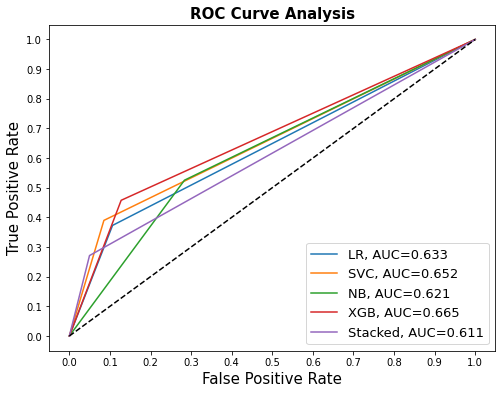

In [25]:
from sklearn.metrics import roc_curve, roc_auc_score

results_table = pd.DataFrame(columns = ['models', 'fpr','tpr','auc'])

predictions = {'LR': y_pred_log, 'SVC': y_pred_svc, 'NB': y_pred_nb, 'XGB': y_pred_xgb, 'Stacked': final_predictions}

for key in predictions:
    fpr, tpr, _ = roc_curve(y_test, predictions[key])
    auc = roc_auc_score(y_test, predictions[key])
    
    results_table = results_table.append({'models': key,
                                         'fpr' : fpr,
                                         'tpr' : tpr,
                                         'auc' : auc}, ignore_index=True)
    
results_table.set_index('models', inplace=True)

print(results_table)

fig = plt.figure(figsize = (8,6))

for i in results_table.index:
    plt.plot(results_table.loc[i]['fpr'], 
             results_table.loc[i]['tpr'], 
             label = "{}, AUC={:.3f}".format(i, results_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color = 'black', linestyle = '--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop = {'size':13}, loc = 'lower right')

plt.show()